In [41]:
%matplotlib inline

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from sklearn import model_selection, preprocessing
import matplotlib.pyplot as plt
import glob
import re
import time
import seaborn as sns
import xgboost as xgb
import pickle
color = sns.color_palette()

In [44]:
DATA_PATH = '/kaggle/dev/sberbank-russian-housing-market-data/'
TRAIN_DATA = DATA_PATH + 'train.csv'
TEST_DATA = DATA_PATH + 'test.csv'
MACRO_DATA = DATA_PATH + 'macro.csv'
MODELS_PATH = '/kaggle/dev/ashish/sberbank-russian-housing-market/models/'

In [3]:
train_df = pd.read_csv(TRAIN_DATA)
macro_df = pd.read_csv(MACRO_DATA)

In [4]:
print(train_df.shape)
train_df

(30471, 292)


,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
0,1,2011-08-20,43,27.0,4.0,NaN,NaN,NaN,NaN,NaN,...,9,4,0,13,22,1,0,52,4,5850000
1,2,2011-08-23,34,19.0,3.0,NaN,NaN,NaN,NaN,NaN,...,15,3,0,15,29,1,10,66,14,6000000
2,3,2011-08-27,43,29.0,2.0,NaN,NaN,NaN,NaN,NaN,...,10,3,0,11,27,0,4,67,10,5700000
3,4,2011-09-01,89,50.0,9.0,NaN,NaN,NaN,NaN,NaN,...,11,2,1,4,4,0,0,26,3,13100000
4,5,2011-09-05,77,77.0,4.0,NaN,NaN,NaN,NaN,NaN,...,319,108,17,135,236,2,91,195,14,16331452
5,6,2011-09-06,67,46.0,14.0,NaN,NaN,NaN,NaN,NaN,...,62,14,1,53,78,1,20,113,17,9100000
6,7,2011-09-08,25,14.0,10.0,NaN,NaN,NaN,NaN,NaN,...,81,16,3,38,80,1,27,127,8,5500000
7,8,2011-09-09,44,44.0,5.0,NaN,NaN,NaN,NaN,NaN,...,9,4,0,11,18,1,0,47,4,2000000
8,9,2011-09-10,42,27.0,5.0,NaN,NaN,NaN,NaN,NaN,...,19,8,1,18,34,1,3,85,11,5300000
9,10,2011-09-13,36,21.0,9.0,NaN,NaN,NaN,NaN,NaN,...,19,13,0,10,20,1,3,67,1,2000000


In [5]:
print(macro_df.shape)
macro_df

(2484, 100)


,timestamp,oil_urals,gdp_quart,gdp_quart_growth,cpi,ppi,gdp_deflator,balance_trade,balance_trade_growth,usdrub,...,provision_retail_space_modern_sqm,turnover_catering_per_cap,theaters_viewers_per_1000_cap,seats_theather_rfmin_per_100000_cap,museum_visitis_per_100_cap,bandwidth_sports,population_reg_sports_share,students_reg_sports_share,apartment_build,apartment_fund_sqm
0,2010-01-01,76.1000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,690.0,6221.0,527.0,0.41,993.0,NaN,NaN,63.03,22825.0,NaN
1,2010-01-02,76.1000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,690.0,6221.0,527.0,0.41,993.0,NaN,NaN,63.03,22825.0,NaN
2,2010-01-03,76.1000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,690.0,6221.0,527.0,0.41,993.0,NaN,NaN,63.03,22825.0,NaN
3,2010-01-04,76.1000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.9050,...,690.0,6221.0,527.0,0.41,993.0,NaN,NaN,63.03,22825.0,NaN
4,2010-01-05,76.1000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.8360,...,690.0,6221.0,527.0,0.41,993.0,NaN,NaN,63.03,22825.0,NaN
5,2010-01-06,76.1000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.7150,...,690.0,6221.0,527.0,0.41,993.0,NaN,NaN,63.03,22825.0,NaN
6,2010-01-07,76.1000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.7750,...,690.0,6221.0,527.0,0.41,993.0,NaN,NaN,63.03,22825.0,NaN
7,2010-01-08,76.1000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.7750,...,690.0,6221.0,527.0,0.41,993.0,NaN,NaN,63.03,22825.0,NaN
8,2010-01-09,76.1000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.7750,...,690.0,6221.0,527.0,0.41,993.0,NaN,NaN,63.03,22825.0,NaN
9,2010-01-10,76.1000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.7750,...,690.0,6221.0,527.0,0.41,993.0,NaN,NaN,63.03,22825.0,NaN


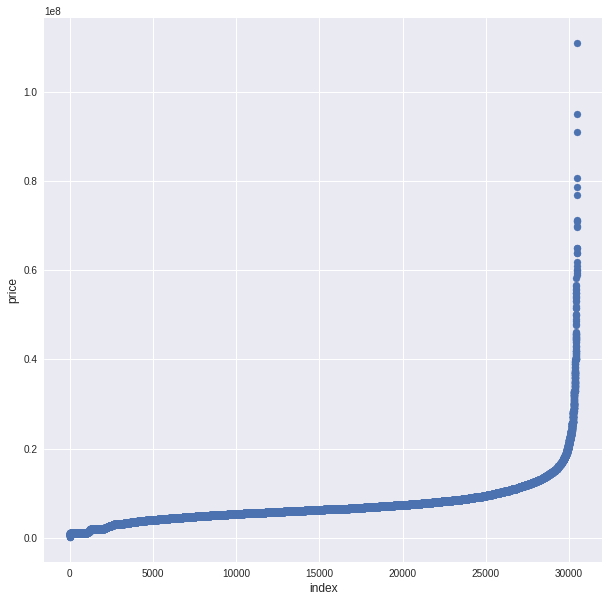

In [6]:
plt.figure(figsize=(10,10))
plt.scatter(range(train_df.shape[0]), np.sort(train_df.price_doc.values))
plt.xlabel('index', fontsize=12)
plt.ylabel('price', fontsize=12)
plt.show()

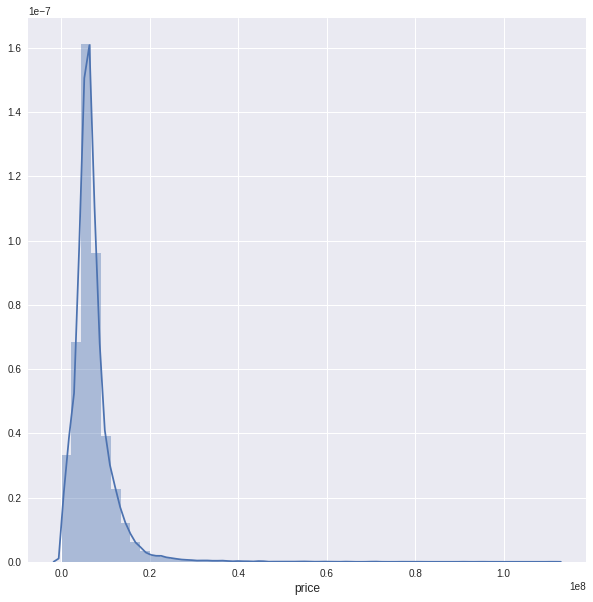

In [7]:
plt.figure(figsize=(10,10))
sns.distplot(train_df.price_doc.values, bins=50, kde=True)
plt.xlabel('price', fontsize=12)
plt.show()

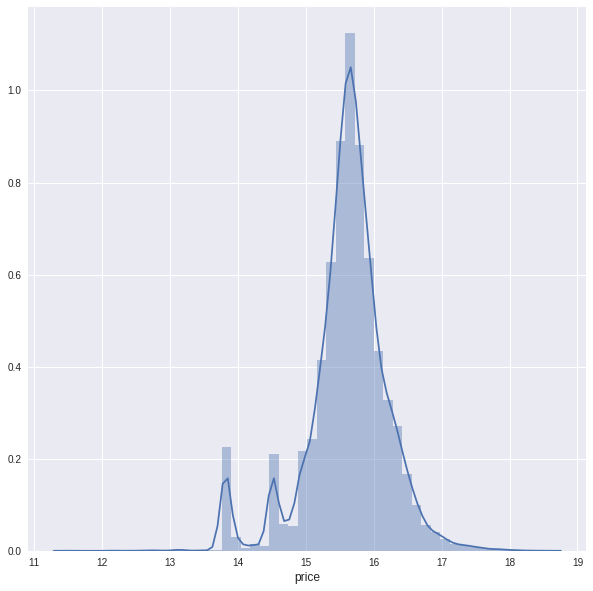

In [8]:
plt.figure(figsize=(10,10))
sns.distplot(np.log(train_df.price_doc.values), bins=50, kde=True)
plt.xlabel('price', fontsize=12)
plt.show()

In [9]:
train_df['yearmonth'] = train_df['timestamp'].apply(lambda x: x[:4] + x[5:7])
grouped_df = train_df.groupby('yearmonth')['price_doc'].aggregate(np.median).reset_index()

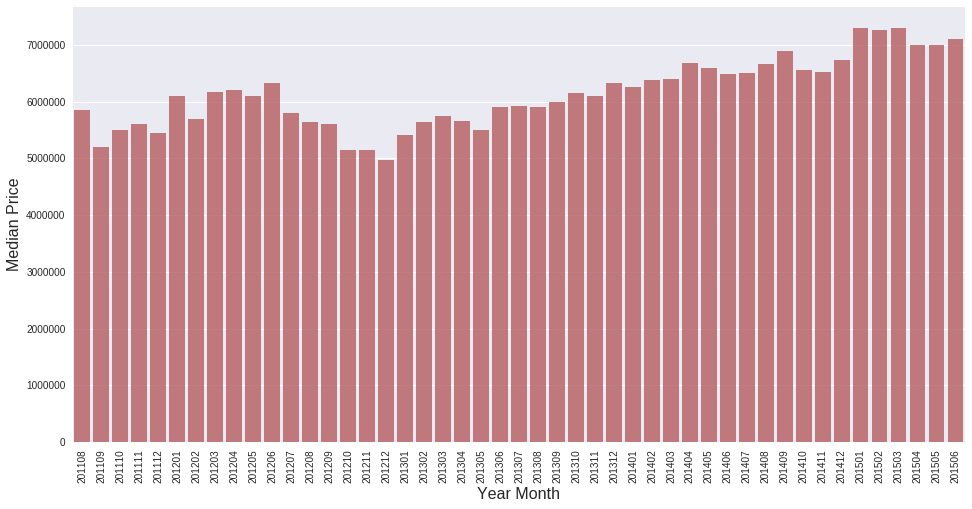

In [10]:
plt.figure(figsize=(16,8))
sns.barplot(grouped_df.yearmonth.values, grouped_df.price_doc.values, alpha=0.8, color=color[2])
plt.ylabel('Median Price', fontsize=16)
plt.xlabel('Year Month', fontsize=16)
plt.xticks(rotation='vertical')
plt.show()

In [11]:
missing_df = train_df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df.ix[missing_df['missing_count']>0]
missing_df = missing_df.sort_values(['column_name'], ascending=[True])
missing_df

,column_name,missing_count
99,ID_railroad_station_walk,25
80,build_count_1921-1945,4991
81,build_count_1946-1970,4991
82,build_count_1971-1995,4991
83,build_count_after_1995,4991
79,build_count_before_1920,4991
69,build_count_block,4991
72,build_count_brick,4991
75,build_count_foam,4991
71,build_count_frame,4991


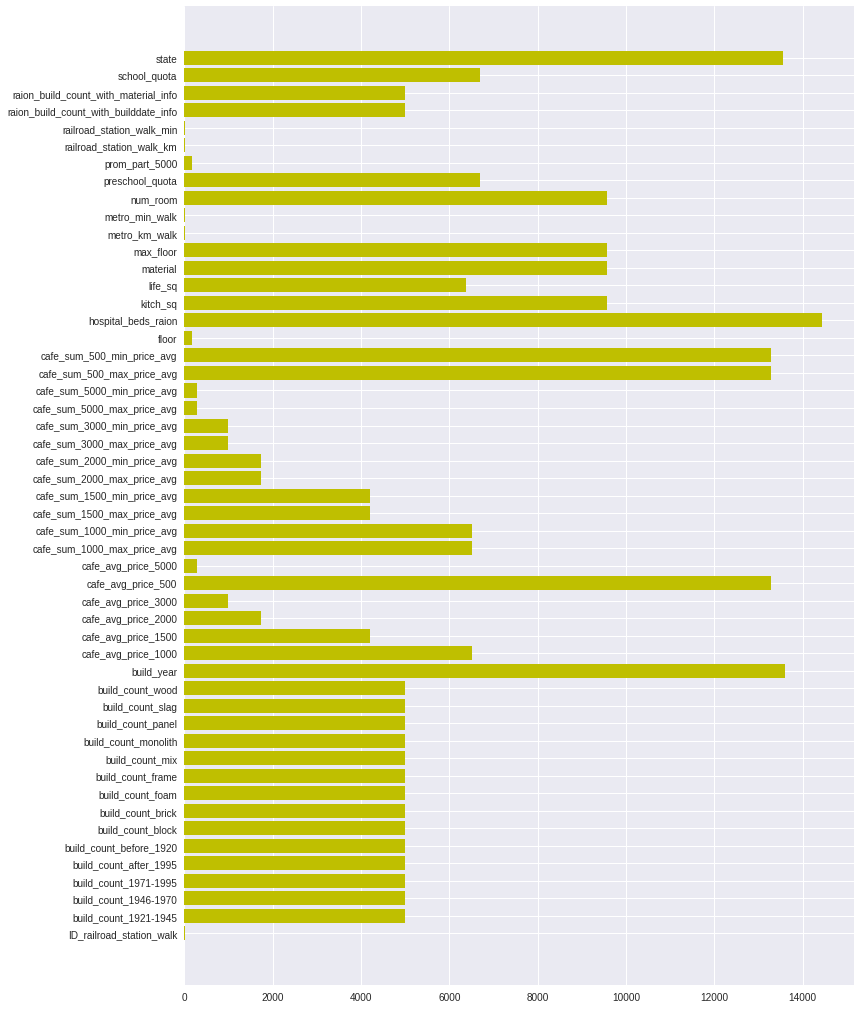

In [12]:
ind = np.arange(missing_df.shape[0])
plt.figure(figsize=(12,18))
fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind, missing_df.missing_count.values, color='y')
ax.set_yticks(ind)
ax.set_yticklabels(missing_df.column_name.values, rotation='horizontal')
plt.show()

In [ ]:
#iter_count = 0

def rmsle(y_predicted, y_true):
    #global iter_count
    #iter_count += 1
    y_pred = y_predicted
    y_label = y_true.get_label()
    temp = np.square(np.log(y_pred + 1.0) - np.log(y_label + 1.0))
    error = np.sqrt(np.sum(temp)/y_pred.shape[0])
    #return ("round-{}]".format(iter_count), error)
    return ("", error)

for f in train_df.columns:
    if train_df[f].dtype=='object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(train_df[f].values))
        train_df[f] = lbl.transform(list(train_df[f].values))

X = train_df.drop(['id', 'timestamp', 'price_doc'], axis=1)
Y = train_df.price_doc.values

train_X, val_X, train_Y, val_Y = model_selection.train_test_split(X, Y, train_size=0.8, random_state=42)

print('train_X.shape', train_X.shape)
print('train_Y.shape', train_Y.shape)
print('val_X.shape', val_X.shape)
print('val_Y.shape', val_Y.shape)
# xgb_params = {
#     'eta': 0.05,
#     'max_depth': 8,
#     'subsample': 0.7,
#     'colsample_bytree': 0.7,
#     'objective': 'reg:linear',
#     'eval_metric': 'rmse'
# }

#dmatrix = xgb.DMatrix(train_X, train_Y, feature_names=train_X.columns.values)
#model = xgb.train(xgb_params, dmatrix, num_boost_round=1000)

model = xgb.XGBRegressor(max_depth=8,
                        gamma=0.5,
                        objective="reg:linear",
                        n_estimators=120000,
                        min_child_weight=6,
                        learning_rate=1,
                        nthread=12,
                        subsample=0.70,
                        colsample_bytree=0.70,
                        seed=42,
                        max_delta_step=1)#,
                        #reg_alpha=0.1,
                        #reg_lambda=0.5)

model.fit(train_X, train_Y, eval_set=[(val_X, val_Y)], verbose=True, eval_metric=rmsle, early_stopping_rounds=50)

pickle.dump(model, open(MODELS_PATH + "model-" + str(int(time.time())) + ".xgb", "wb"))

train_X.shape (24376, 290)
train_Y.shape (24376,)
val_X.shape (6095, 290)
val_Y.shape (6095,)
[0]	validation_0-:14.6946
Will train until validation_0- hasn't improved in 50 rounds.
[1]	validation_0-:14.3584
[2]	validation_0-:14.1073
[3]	validation_0-:13.9068
[4]	validation_0-:13.7399
[5]	validation_0-:13.5969
[6]	validation_0-:13.4719
[7]	validation_0-:13.3608
[8]	validation_0-:13.2608
[9]	validation_0-:13.1699
[10]	validation_0-:13.0866
[11]	validation_0-:13.0098
[12]	validation_0-:12.9384
[13]	validation_0-:12.8718
[14]	validation_0-:12.8093
[15]	validation_0-:12.7505
[16]	validation_0-:12.695
[17]	validation_0-:12.6424
[18]	validation_0-:12.5925
[19]	validation_0-:12.5449
[20]	validation_0-:12.4995
[21]	validation_0-:12.4561
[22]	validation_0-:12.4144
[23]	validation_0-:12.3745
[24]	validation_0-:12.3361
[25]	validation_0-:12.2991
[26]	validation_0-:12.2634
[27]	validation_0-:12.229
[28]	validation_0-:12.1957
[29]	validation_0-:12.1634
[30]	validation_0-:12.1322
[31]	validation_0-:1

[293]	validation_0-:9.92812
[294]	validation_0-:9.92475
[295]	validation_0-:9.92139
[296]	validation_0-:9.91804
[297]	validation_0-:9.9147
[298]	validation_0-:9.91137
[299]	validation_0-:9.90806
[300]	validation_0-:9.90475
[301]	validation_0-:9.90146
[302]	validation_0-:9.89818
[303]	validation_0-:9.8949
[304]	validation_0-:9.89164
[305]	validation_0-:9.88839
[306]	validation_0-:9.88515
[307]	validation_0-:9.88192
[308]	validation_0-:9.8787
[309]	validation_0-:9.87549
[310]	validation_0-:9.87229
[311]	validation_0-:9.8691
[312]	validation_0-:9.86592
[313]	validation_0-:9.86275
[314]	validation_0-:9.85959
[315]	validation_0-:9.85645
[316]	validation_0-:9.85331
[317]	validation_0-:9.85018
[318]	validation_0-:9.84706
[319]	validation_0-:9.84395
[320]	validation_0-:9.84085
[321]	validation_0-:9.83776
[322]	validation_0-:9.83468
[323]	validation_0-:9.83161
[324]	validation_0-:9.82855
[325]	validation_0-:9.82549
[326]	validation_0-:9.82245
[327]	validation_0-:9.81942
[328]	validation_0-:9.81

[587]	validation_0-:9.23888
[588]	validation_0-:9.23719
[589]	validation_0-:9.2355
[590]	validation_0-:9.23382
[591]	validation_0-:9.23214
[592]	validation_0-:9.23046
[593]	validation_0-:9.22878
[594]	validation_0-:9.2271
[595]	validation_0-:9.22543
[596]	validation_0-:9.22376
[597]	validation_0-:9.2221
[598]	validation_0-:9.22044
[599]	validation_0-:9.21878
[600]	validation_0-:9.21712
[601]	validation_0-:9.21546
[602]	validation_0-:9.21381
[603]	validation_0-:9.21216
[604]	validation_0-:9.21051
[605]	validation_0-:9.20887
[606]	validation_0-:9.20723
[607]	validation_0-:9.20559
[608]	validation_0-:9.20396
[609]	validation_0-:9.20232
[610]	validation_0-:9.20069
[611]	validation_0-:9.19906
[612]	validation_0-:9.19744
[613]	validation_0-:9.19582
[614]	validation_0-:9.1942
[615]	validation_0-:9.19258
[616]	validation_0-:9.19096
[617]	validation_0-:9.18935
[618]	validation_0-:9.18774
[619]	validation_0-:9.18614
[620]	validation_0-:9.18453
[621]	validation_0-:9.18293
[622]	validation_0-:9.18